<a href="https://colab.research.google.com/github/Tavo826/Rainfall-prediction/blob/main/Rainfall_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### TEMAS:

* Balanceo de datos
* Codificaciónde etiquetas para variables categóricas
* Imputación sofsticada (MICE)
* Detectar datos atípicos
* Selección de características
* Comparación de velocidad y compensación
* Métricas para datos desbalanceados (Accuracy, F1-Score, Cohen's Kappa)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#Importando datos

import pandas as pd
full_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Deep Learning/weatherAUS.csv')
full_data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


In [ ]:
#Data exploration

print('tamaño dataset: ', full_data.shape)
full_data.info()

tamaño dataset:  (142193, 24)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustDir    132863 non-null  object 
 8   WindGustSpeed  132923 non-null  float64
 9   WindDir9am     132180 non-null  object 
 10  WindDir3pm     138415 non-null  object 
 11  WindSpeed9am   140845 non-null  float64
 12  WindSpeed3pm   139563 non-null  float64
 13  Humidity9am    140419 non-null  float64
 14  Humidity3pm    138583 non-null  float64
 15  Pressure9am    128179 non-null  float64
 16  Pressure3pm    128212 non-null  float64
 17 

**RainToday** y **RainTomorrow** son objetos (Yes/No). Se desea convertir en binario

In [ ]:
full_data['RainToday'].replace({'No': 0, 'Yes': 1}, inplace=True)
full_data['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace=True)

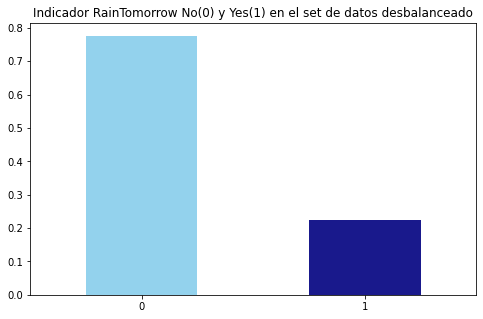

In [ ]:
#Qué tan desbalanceados están los datos

import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,5))
full_data.RainTomorrow.value_counts(normalize=True).plot(kind='bar',
                                                         color=['skyblue','navy'],
                                                         alpha=0.9,
                                                         rot=0)
plt.title('Indicador RainTomorrow No(0) y Yes(1) en el set de datos desbalanceado')
plt.show()

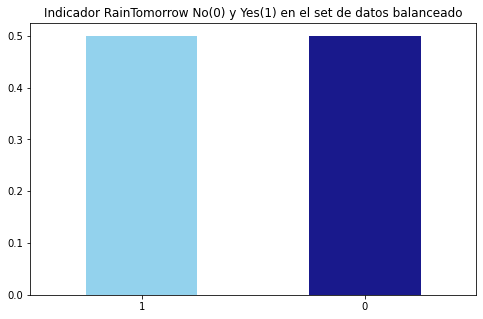

In [ ]:
#Sobremuestreando la clase minoritaria

from sklearn.utils import resample

no = full_data[full_data.RainTomorrow == 0]
yes = full_data[full_data.RainTomorrow == 1]
yes_oversampled = resample(yes, 
                           replace=True, 
                           n_samples=len(no), 
                           random_state=123)

oversampled = pd.concat([no, yes_oversampled])

fig = plt.figure(figsize = (8,5))
oversampled.RainTomorrow.value_counts(normalize=True).plot(kind='bar',
                                                         color=['skyblue','navy'],
                                                         alpha=0.9,
                                                         rot=0)
plt.title('Indicador RainTomorrow No(0) y Yes(1) en el set de datos balanceado')
plt.show()

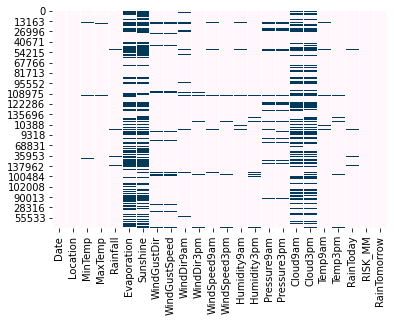

In [ ]:
#Datos perdidos

import seaborn as sns
sns.heatmap(oversampled.isnull(), cbar=False, cmap='PuBu')

In [ ]:
#Se enfoca en 'Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm'

total = oversampled.isnull().sum().sort_values(ascending=False)
percent = (oversampled.isnull().sum() / oversampled.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1,
                    keys=['Total', 'Percents'])

missing.head(4)

,Total,Percents
Sunshine,104831,0.475140
Evaporation,95411,0.432444
Cloud3pm,85614,0.388040
Cloud9am,81339,0.368664


EStas características tienen <50\% de datos perdidos. En lugar de descartarlas, seconsideran con **proper imputation**

## Imputación y tranformacción

Se imputan las columnas categóricas con modo, y luego se usa el codificador de etiquetas para convertirlas en numéricas. Se imputan los valores faltantes (NaN, etc.) usando el paquete MICE (Imputación múltiple por ecuaciones encadenadas). 

Posteriormente, se detectan los valores atípicos utilizando el rango intercuartil y se eliminan para obtener el conjunto de datos de trabajo final.

Finalmente, se comprueba la correlación entre diferentes variables, y si hay algún par de variables altamente correlacionadas, se descarta una manteniendo la otra.

In [ ]:
oversampled.select_dtypes(include=['object']).columns

Index(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype='object')

In [ ]:
# Imputando variables categóricas

oversampled['Date'] = oversampled['Date'].fillna(oversampled['Date'].mode()[0])
oversampled['Location'] = oversampled['Location'].fillna(oversampled['Location'].mode()[0])
oversampled['WindGustDir'] = oversampled['WindGustDir'].fillna(oversampled['WindGustDir'].mode()[0])
oversampled['WindDir9am'] = oversampled['WindDir9am'].fillna(oversampled['WindDir9am'].mode()[0])
oversampled['WindDir3pm'] = oversampled['WindDir3pm'].fillna(oversampled['WindDir3pm'].mode()[0])

In [ ]:
#Convirtiendo características categóricas en continuas con Label Encoding

from sklearn.preprocessing import LabelEncoder
lencoders = {}
for col in oversampled.select_dtypes(include=['object']).columns:
  lencoders[col] = LabelEncoder()
  oversampled[col] = lencoders[col].fit_transform(oversampled[col])

In [ ]:
# Imputación múltiple con Chained Equations
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

MiceImputed = oversampled.copy(deep=True)
mice_imputer = IterativeImputer()
MiceImputed.iloc[:, :] = mice_imputer.fit_transform(oversampled)

/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [ ]:
print(MiceImputed.shape)
MiceImputed.head()

(220632, 24)


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,396.0,2.0,13.4,22.9,0.6,5.735438,7.364116,13.0,44.0,13.0,14.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.000000,4.868720,16.9,21.8,0.0,0.0,0.0
1,397.0,2.0,7.4,25.1,0.0,5.639582,11.470601,14.0,44.0,6.0,15.0,4.0,22.0,44.0,25.0,1010.6,1007.8,1.734671,2.639541,17.2,24.3,0.0,0.0,0.0
2,398.0,2.0,12.9,25.7,0.0,7.762987,12.281872,15.0,46.0,13.0,15.0,19.0,26.0,38.0,30.0,1007.6,1008.7,1.820254,2.000000,21.0,23.2,0.0,0.0,0.0
3,399.0,2.0,9.2,28.0,0.0,5.977338,11.743982,4.0,24.0,9.0,0.0,11.0,9.0,45.0,16.0,1017.6,1012.8,1.236006,2.133027,18.1,26.5,0.0,1.0,0.0
4,400.0,2.0,17.5,32.3,1.0,6.852950,5.756442,13.0,41.0,1.0,7.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.000000,8.000000,17.8,29.7,0.0,0.2,0.0


In [ ]:
MiceImputed.isna()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130416,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
114384,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
84962,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
54992,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
#Detectando y descartando los datos atípicos

Q1 = MiceImputed.quantile(0.25)
Q3 = MiceImputed.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Date             1535.000000
Location           25.000000
MinTemp             9.300000
MaxTemp            10.200000
Rainfall            2.400000
Evaporation         4.119679
Sunshine            5.947404
WindGustDir         9.000000
WindGustSpeed      19.000000
WindDir9am          8.000000
WindDir3pm          8.000000
WindSpeed9am       13.000000
WindSpeed3pm       11.000000
Humidity9am        26.000000
Humidity3pm        30.000000
Pressure9am         8.800000
Pressure3pm         8.800000
Cloud9am            4.000000
Cloud3pm            3.681346
Temp9am             9.300000
Temp3pm             9.800000
RainToday           1.000000
RISK_MM             5.200000
RainTomorrow        1.000000
dtype: float64


In [ ]:
#Removiendo los atípicos

MiceImputed = MiceImputed[~((MiceImputed < (Q1 - 1.5 * IQR)) | (MiceImputed > (Q3 + 1.5 * IQR))).any(axis=1)]
MiceImputed.shape

(156852, 24)

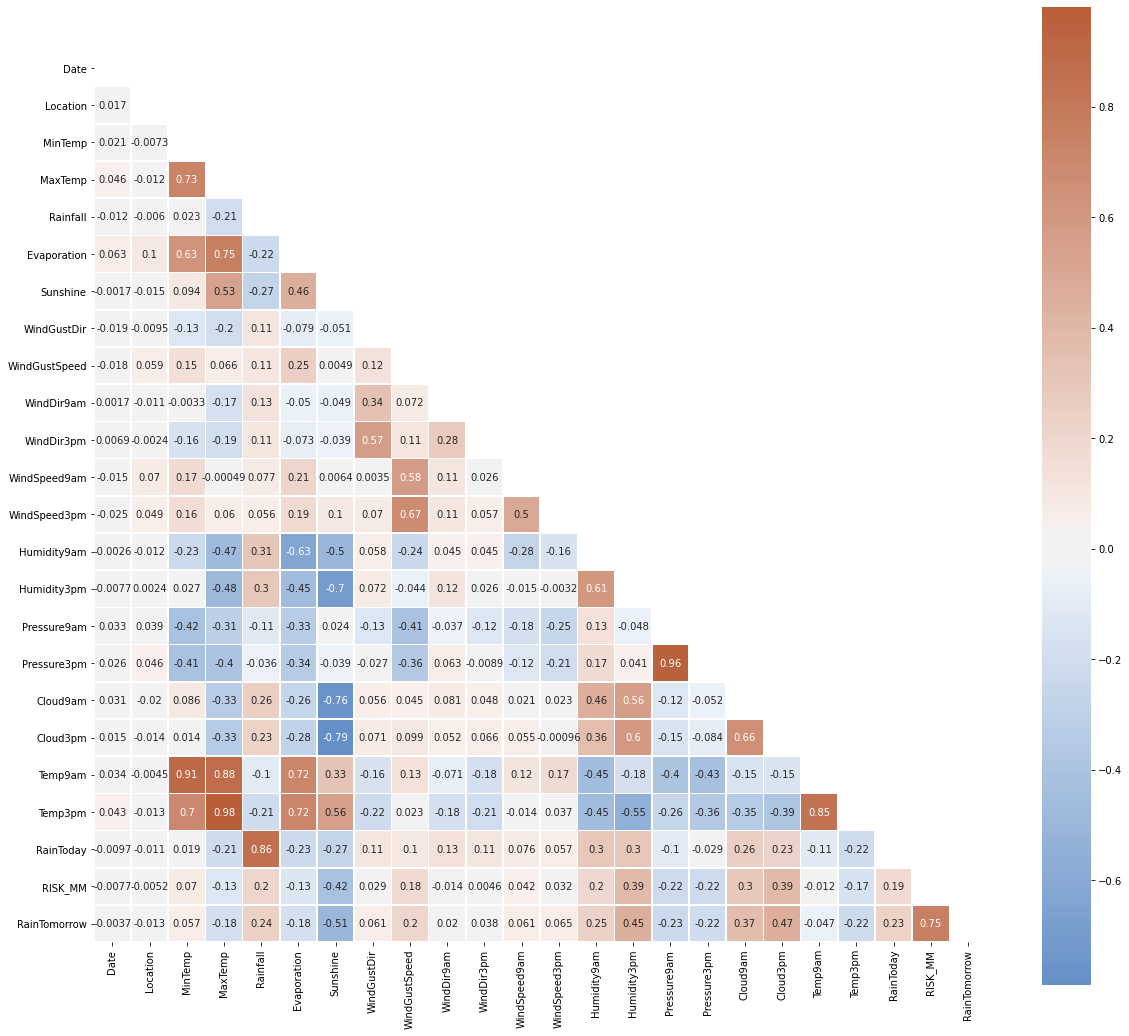

In [ ]:
#Correlaciones

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

corr = MiceImputed.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(20,20))
cmap = sns.diverging_palette(250, 25, as_cmap=True)
sns.heatmap(corr, 
            mask=mask, 
            cmap=cmap, 
            vmax=None,
            center=0,
            square=True,
            annot=True,
            linewidths=.5,
            cbar_kws={'shrink': .9})

Hay una alta correlación entre:

* MaxTemp y MinTemp
* Pressure9am y Presure3pm
* Temp9am y Temp3pm
* Evaporation y MaxTemp
* MaxTemp y Temp3pm

Ningún valor de correlación es 1, por esta razón no se descarta ninguna característica

Se puede analizar más profundamente las correlaciones encontradas

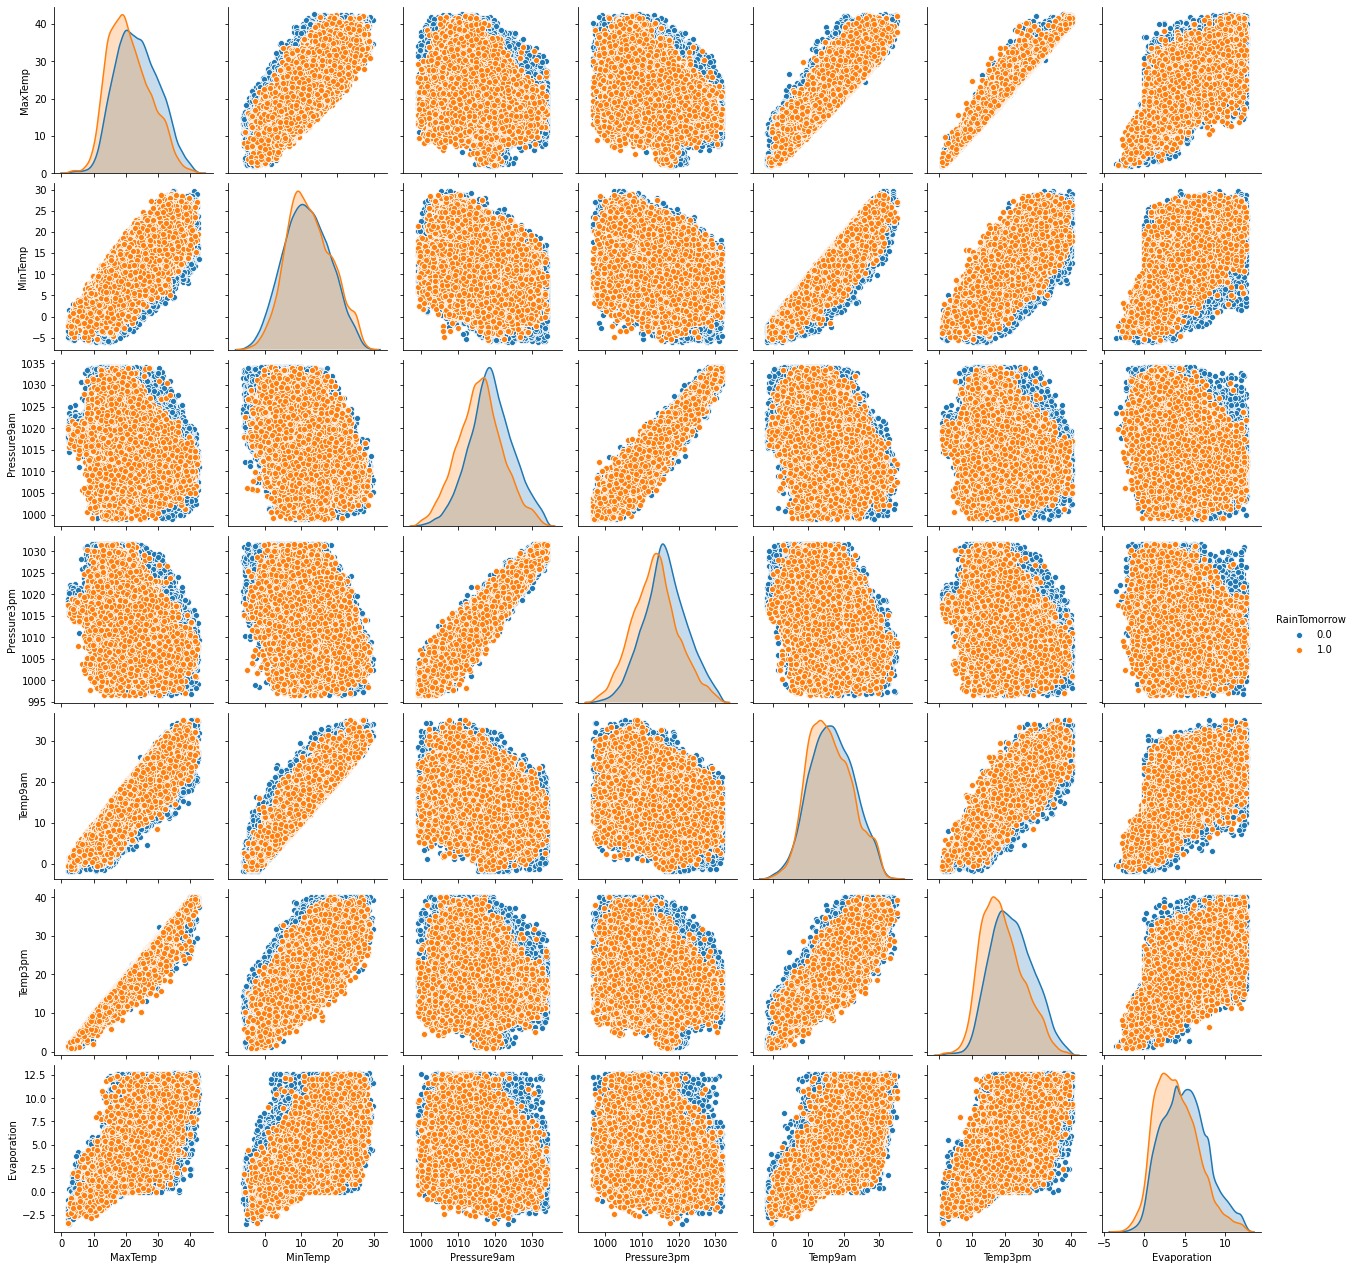

In [ ]:
sns.pairplot(data=MiceImputed, vars=('MaxTemp',
                                     'MinTemp',
                                     'Pressure9am',
                                     'Pressure3pm',
                                     'Temp9am',
                                     'Temp3pm',
                                     'Evaporation'), hue='RainTomorrow')

## Selección de caracterísiticas

### Selección de características con el método del filtro (Chi-Square Value)

Primero se necesita estandarizar los datos, en este caso se usa MinMaxScaler

In [ ]:
from sklearn import preprocessing

r_scaler = preprocessing.MinMaxScaler()
r_scaler.fit(MiceImputed)
modified_data = pd.DataFrame(r_scaler.transform(MiceImputed), 
                             index=MiceImputed.index,
                             columns=MiceImputed.columns)

modified_data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,0.115284,0.041667,0.543417,0.514778,0.432327,0.569942,0.502581,0.866667,0.521127,0.866667,0.933333,0.551153,0.615385,0.551722,0.220253,0.245714,0.298295,0.866337,0.420182,0.506775,0.530612,0.247121,0.000000,0.0
1,0.115575,0.041667,0.375350,0.568966,0.369252,0.564016,0.741068,0.933333,0.521127,0.400000,1.000000,0.173177,0.564103,0.247712,0.250243,0.328571,0.318182,0.338787,0.227798,0.514905,0.594388,0.247121,0.000000,0.0
2,0.115866,0.041667,0.529412,0.583744,0.369252,0.695290,0.788183,1.000000,0.549296,0.866667,1.000000,0.527530,0.666667,0.180154,0.300227,0.242857,0.343750,0.345994,0.172605,0.617886,0.566327,0.247121,0.000000,0.0
3,0.116157,0.041667,0.425770,0.640394,0.369252,0.584897,0.756945,0.266667,0.239437,0.600000,0.000000,0.338542,0.230769,0.258971,0.160272,0.528571,0.460227,0.296799,0.184085,0.539295,0.650510,0.247121,0.076923,0.0
4,0.116448,0.041667,0.658263,0.746305,0.474377,0.639029,0.409215,0.866667,0.478873,0.066667,0.466667,0.244048,0.512821,0.675577,0.330217,0.334286,0.267045,0.782136,0.690418,0.531165,0.732143,0.247121,0.015385,0.0


In [ ]:
# 1 - Chi-Square

from sklearn.feature_selection import SelectKBest, chi2
X = modified_data.loc[:, modified_data.columns != 'RainTomorrow']
y = modified_data[['RainTomorrow']]
selector = SelectKBest(chi2, k=10)
selector.fit(X, y)
X_new = selector.transform(X)
print(X.columns[selector.get_support(indices=True)])

Index(['Sunshine', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm',
       'Cloud9am', 'Cloud3pm', 'Temp3pm', 'RainToday', 'RISK_MM'],
      dtype='object')


Esas características son las que tienen más importancia sobre las otras

### Selección de características con el método wrapper (Random Forest)

In [ ]:
# 2 - Random Forest

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as rf

X = MiceImputed.drop('RainTomorrow', axis=1)
y = MiceImputed['RainTomorrow']

selector = SelectFromModel(rf(n_estimators=100, random_state=0))
selector.fit(X, y)

support = selector.get_support()
features = X.loc[:, support].columns.tolist()

print(features)
print(rf(n_estimators=100, 
         random_state=0).fit(X, y).feature_importances_)

['Sunshine', 'Cloud3pm', 'RISK_MM']
[0.00205993 0.00215407 0.00259089 0.00367568 0.0102656  0.00252838
 0.05894157 0.00143001 0.00797518 0.00177178 0.00167654 0.0014278
 0.00187743 0.00760691 0.03091966 0.00830365 0.01193018 0.02113544
 0.04962418 0.00270103 0.00513723 0.00352198 0.76074491]


Todas las características, excepto RISK_MM, tienen la importancia cerca a cero. Esto es posible en 2 escenarios:

* Cuando todas las características tienen una alta correlación entre ellas
* Cuando las características tienen una muy baja importancia con la variable objetivo

Como ya se comprobó la poca correlación entre las características, la primera opción no es posible

Se analiza la segunda opción usando **Permutation Importance**

In [ ]:
!pip install eli5

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rf(n_estimators=100,
                                random_state=0).fit(X, y),
                             random_state=1).fit(X, y)

eli5.show_weights(perm, feature_names = X.columns.tolist())                            

Weight,Feature
0.4749 ± 0.0016,RISK_MM
0 ± 0.0000,MaxTemp
0 ± 0.0000,Rainfall
0 ± 0.0000,Evaporation
0 ± 0.0000,Sunshine
0 ± 0.0000,WindGustDir
0 ± 0.0000,WindGustSpeed
0 ± 0.0000,WindDir9am
0 ± 0.0000,WindDir3pm
0 ± 0.0000,Cloud3pm


Todas las características tienen una muy baja importancia con respecto a la variable 'RainTomorrow'

Dado que la variable 'RISK_MM' contiene información directamente sobre la variable objetivo, incluirla filtraría la información futura al modelo. 'Date' también se excluye ya que no agrega ninguna relevancia al contexto actual

# Entrenando con diferentes modelos

In [ ]:
features = MiceImputed[['Location',
                        'MinTemp',
                        'MaxTemp',
                        'Rainfall',
                        'Evaporation',
                        'Sunshine',
                        'WindGustDir',
                        'WindGustSpeed',
                        'WindDir9am',
                        'WindDir3pm',
                        'WindSpeed9am',
                        'WindSpeed3pm',
                        'Humidity9am',
                        'Humidity3pm',
                        'Pressure9am',
                        'Pressure3pm',
                        'Cloud9am',
                        'Cloud3pm',
                        'Temp9am',
                        'Temp3pm',
                        'RainToday',]]

target = MiceImputed['RainTomorrow']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    target,
                                                    test_size=0.25,
                                                    random_state=12345)

#Normalizando
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [ ]:
def plot_roc_cur(fper, tper):
  plt.plot(fper, tper, color='orange', label='ROC')
  plt.plot([0,1], [0,1], color='darkblue', linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend()
  plt.show()

In [ ]:
import time
from sklearn.metrics import accuracy_score, roc_auc_score, cohen_kappa_score, plot_confusion_matrix, roc_curve, classification_report

def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
  
  t0 = time.time()

  if verbose == False:
    model.fit(X_train, y_train, verbose=0)
  else:
    model.fit(X_train, y_train)

  y_pred = model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  roc_auc = roc_auc_score(y_test, y_pred)
  coh_kap = cohen_kappa_score(y_test, y_pred)
  time_taken = time.time() - t0

  print('Accuracy = {}'.format(accuracy))
  print('ROC Area Under Curve = {}'.format(roc_auc))
  print("Cohen's Kappa = {}".format(coh_kap))
  print("Time taken = {}".format(time_taken))
  print(classification_report(y_test, y_pred, digits=5))

  probs = model.predict_proba(X_test)
  probs = probs[:, 1]
  fper, tper, thresholds = roc_curve(y_test, probs)
  plot_roc_cur(fper, tper)

  plot_confusion_matrix(model, 
                        X_test, 
                        y_test, 
                        cmap=plt.cm.Blues,
                        normalize='all')
  
  return model, accuracy, roc_auc, coh_kap, time_taken

## Model-1: Logistic Regression penalized by Lasso

Accuracy = 0.78963609007217
ROC Area Under Curve = 0.76976981489154
Cohen's Kappa = 0.5494516226632338
Time taken = 3.5393199920654297
              precision    recall  f1-score   support

         0.0    0.80822   0.85949   0.83307     23948
         1.0    0.75520   0.68005   0.71566     15265

    accuracy                        0.78964     39213
   macro avg    0.78171   0.76977   0.77436     39213
weighted avg    0.78758   0.78964   0.78736     39213



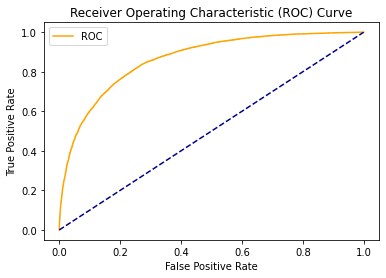

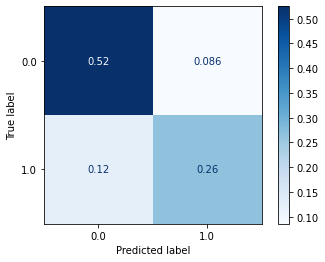

In [ ]:
from sklearn.linear_model import LogisticRegression

params_lr = {'penalty': 'l1', 'solver': 'liblinear'}

model_lr = LogisticRegression(**params_lr)
model_lr, accuracy_lr, roc_auc_lr, coh_kap_lr, tt_lr = run_model(model_lr,
                                                                 X_train,
                                                                 y_train,
                                                                 X_test,
                                                                 y_test)

## Model-2: Decision Tree

Accuracy = 0.8656822992374977
ROC Area Under Curve = 0.8633826082180132
Cohen's Kappa = 0.7201031962616838
Time taken = 0.5093073844909668
              precision    recall  f1-score   support

         0.0    0.90315   0.87377   0.88821     23948
         1.0    0.81158   0.85300   0.83177     15265

    accuracy                        0.86568     39213
   macro avg    0.85736   0.86338   0.85999     39213
weighted avg    0.86750   0.86568   0.86624     39213



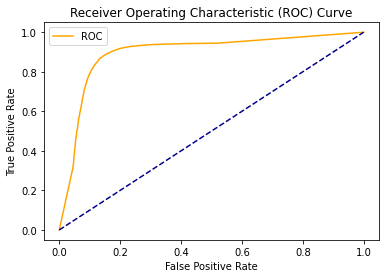

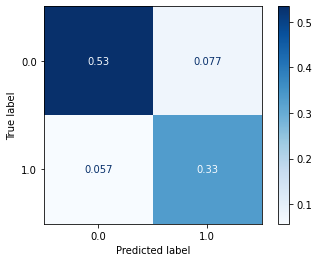

In [ ]:
from sklearn.tree import DecisionTreeClassifier

params_dt = {'max_depth': 16,
             'max_features': 'sqrt'}

model_dt = DecisionTreeClassifier(**params_dt)             
model_dt, accuracy_dt, roc_auc_dt, coh_kap_dt, tt_dt = run_model(model_dt, 
                                                                 X_train,
                                                                 y_train,
                                                                 X_test,
                                                                 y_test)

## Model-3: Neuran Network (Multilayer Preceptron)


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy = 0.8690740315711626
ROC Area Under Curve = 0.8615277801105365
Cohen's Kappa = 0.7242080627876816
Time taken = 344.7519271373749
              precision    recall  f1-score   support

         0.0    0.89062   0.89561   0.89311     23948
         1.0    0.83478   0.82745   0.83110     15265

    accuracy                        0.86907     39213
   macro avg    0.86270   0.86153   0.86210     39213
weighted avg    0.86888   0.86907   0.86897     39213



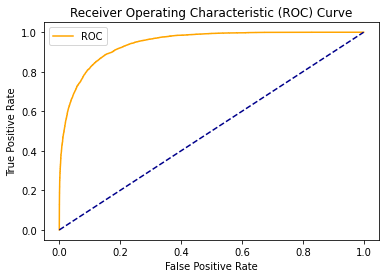

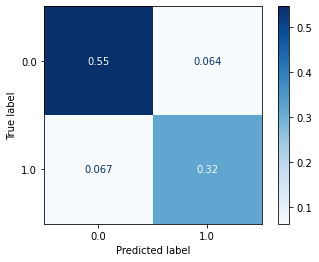

In [ ]:
from sklearn.neural_network import MLPClassifier

params_nn = {'hidden_layer_sizes': (30,30,30),
             'activation': 'logistic',
             'solver': 'lbfgs',
             'max_iter': 500}

model_nn = MLPClassifier(**params_nn)             
model_nn, accuracy_nn, roc_auc_nn, coh_kap_nn, tt_nn = run_model(model_nn,
                                                                 X_train,
                                                                 y_train,
                                                                 X_test,
                                                                 y_test)

## Model-4: Random Forest

Accuracy = 0.9280595720806876
ROC Area Under Curve = 0.9265770863620824
Cohen's Kappa = 0.8493714659078331
Time taken = 30.694611310958862
              precision    recall  f1-score   support

         0.0    0.94812   0.93327   0.94064     23948
         1.0    0.89783   0.91988   0.90872     15265

    accuracy                        0.92806     39213
   macro avg    0.92297   0.92658   0.92468     39213
weighted avg    0.92854   0.92806   0.92821     39213



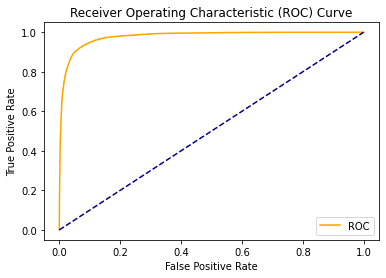

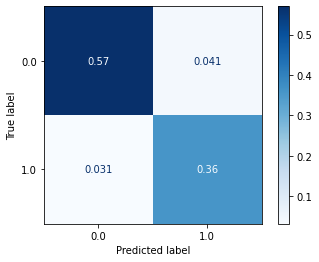

In [ ]:
from sklearn.ensemble import RandomForestClassifier

params_rf = {'max_depth': 16,
             'min_samples_leaf': 1,
             'min_samples_split': 2,
             'n_estimators': 100,
             'random_state': 12345}

model_rf = RandomForestClassifier(**params_rf)             
model_rf, accuracy_rf, roc_auc_rf, coh_kap_rf, tt_rf = run_model(model_rf,
                                                                 X_train,
                                                                 y_train,
                                                                 X_test,
                                                                 y_test)

## Model-5: Light GBM

Accuracy = 0.8714711957769107
ROC Area Under Curve = 0.8626590389013514
Cohen's Kappa = 0.7285019253916413
Time taken = 7.298476457595825
              precision    recall  f1-score   support

         0.0    0.88880   0.90246   0.89557     23948
         1.0    0.84319   0.82286   0.83290     15265

    accuracy                        0.87147     39213
   macro avg    0.86599   0.86266   0.86424     39213
weighted avg    0.87104   0.87147   0.87118     39213



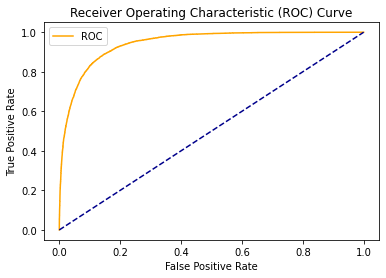

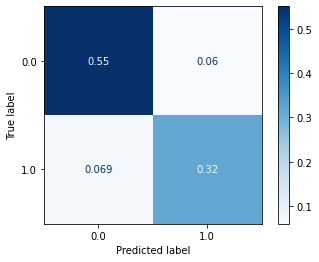

In [ ]:
import lightgbm as lgb

params_lgb = {'colsample_bytree': 0.95,
              'max_depth': 16,
              'min_split_gain': 0.1,
              'n_estimators': 200,
              'num_leaves': 50,
              'reg_alpha': 1.2,
              'reg_lambda': 1.2,
              'subsample': 0.95,
              'subsample_freq': 20}

model_lgb = lgb.LGBMClassifier(**params_lgb)
model_lgb, accuracy_lgb, roc_auc_lgb, coh_kap_lgb, tt_lgb = run_model(model_lgb,
                                                                      X_train,
                                                                      y_train,
                                                                      X_test,
                                                                      y_test)

## Model-6: CatBoost

In [ ]:
!pip install catboost

Learning rate set to 0.5
0:	learn: 0.4489116	total: 6.33s	remaining: 5m 10s
1:	learn: 0.3691760	total: 11.4s	remaining: 4m 33s
2:	learn: 0.3238146	total: 16.5s	remaining: 4m 18s
3:	learn: 0.2897989	total: 21.6s	remaining: 4m 8s
4:	learn: 0.2683204	total: 26.7s	remaining: 3m 59s
5:	learn: 0.2497803	total: 31.7s	remaining: 3m 52s
6:	learn: 0.2244045	total: 36.8s	remaining: 3m 46s
7:	learn: 0.2025651	total: 41.9s	remaining: 3m 39s
8:	learn: 0.1722817	total: 47.1s	remaining: 3m 34s
9:	learn: 0.1595317	total: 52.2s	remaining: 3m 28s
10:	learn: 0.1505421	total: 57.2s	remaining: 3m 22s
11:	learn: 0.1416682	total: 1m 2s	remaining: 3m 17s
12:	learn: 0.1288745	total: 1m 7s	remaining: 3m 12s
13:	learn: 0.1195407	total: 1m 12s	remaining: 3m 6s
14:	learn: 0.1087741	total: 1m 17s	remaining: 3m 1s
15:	learn: 0.1015974	total: 1m 22s	remaining: 2m 56s
16:	learn: 0.0928947	total: 1m 28s	remaining: 2m 50s
17:	learn: 0.0895648	total: 1m 33s	remaining: 2m 45s
18:	learn: 0.0843351	total: 1m 38s	remaining: 2

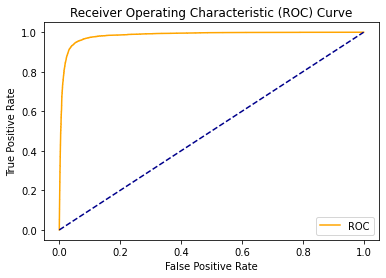

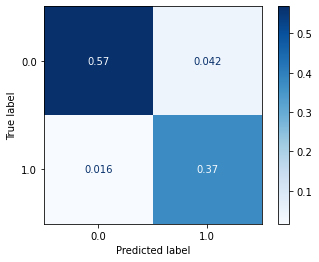

In [ ]:
import catboost as cb

params_cb = {'iterations': 50,
             'max_depth': 16}

model_cb = cb.CatBoostClassifier(**params_cb)
model_cb, accuracy_cb, roc_auc_cb, coh_kap_cb, tt_cb = run_model(model_cb,
                                                                 X_train,
                                                                 y_train,
                                                                 X_test,
                                                                 y_test)             

## Model-7: XGBoost

Accuracy = 0.9562135006247928
ROC Area Under Curve = 0.9562895184899743
Cohen's Kappa = 0.9083395381846924
Time taken = 425.0879487991333
              precision    recall  f1-score   support

         0.0    0.97190   0.95595   0.96385     23948
         1.0    0.93262   0.95663   0.94447     15265

    accuracy                        0.95621     39213
   macro avg    0.95226   0.95629   0.95416     39213
weighted avg    0.95661   0.95621   0.95631     39213



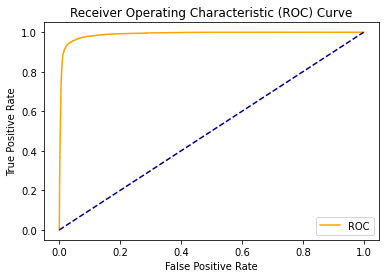

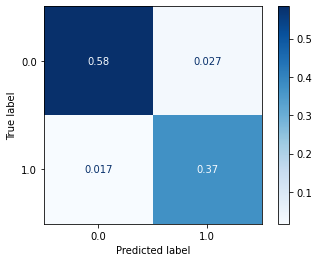

In [ ]:
import xgboost as xgb

params_xgb = {'n_estimators': 550,
              'max_depth': 16}

model_xgb = xgb.XGBClassifier(**params_xgb)              
model_xgb, accuracy_xgb, roc_auc_xgb, coh_kap_xgb, tt_xgb = run_model(model_xgb,
                                                                      X_train,
                                                                      y_train,
                                                                      X_test,
                                                                      y_test)

# Graficando la regiónde decisión para todos los modelos

/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())
/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max

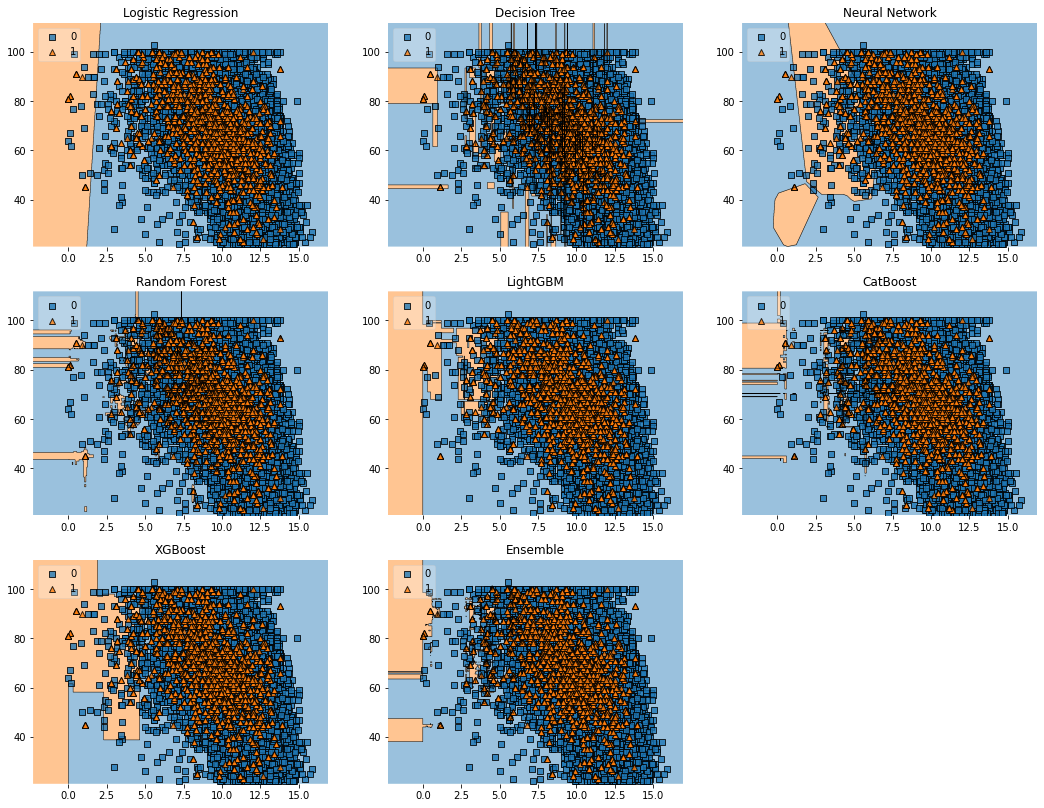

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import catboost as cb
import xgboost as xgb
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.plotting import plot_decision_regions

value = 1.8
width = 0.9

clf1 = LogisticRegression(random_state=12345)
clf2 = DecisionTreeClassifier(random_state=12345)
clf3 = MLPClassifier(random_state=12345, verbose=0)
clf4 = RandomForestClassifier(random_state=12345)
clf5 = lgb.LGBMClassifier(random_state=12345, verbose=0)
clf6 = cb.CatBoostClassifier(random_state=12345, verbose=0)
clf7 = xgb.XGBClassifier(random_state=12345)

eclf = EnsembleVoteClassifier(clfs=[clf4,
                                    clf5,
                                    clf6,
                                    clf7],
                              weights=[1,1,1,1],
                              voting='soft')

#Características importantes
X_list = MiceImputed[['Sunshine', 'Humidity9am', 'Cloud3pm']]
X = np.asarray(X_list, dtype=np.float32)
y_list = MiceImputed['RainTomorrow']
y = np.asarray(y_list, dtype=np.int32)

#Graficando

gs = gridspec.GridSpec(3,3)
fig = plt.figure(figsize=(18,14))

labels = ['Logistic Regression',
          'Decision Tree',
          'Neural Network',
          'Random Forest',
          'LightGBM',
          'CatBoost',
          'XGBoost',
          'Ensemble']

for clf, lab, grd in zip([clf1, clf2, clf3, clf4, clf5, clf6, clf7, eclf],
                         labels,
                         itertools.product([0,1,2],
                                           repeat=2)):
  
  clf.fit(X, y)
  ax = plt.subplot(gs[grd[0], grd[1]])
  fig = plot_decision_regions(X=X, y=y, clf=clf,
                              filler_feature_values = {2: value},
                              filler_feature_ranges = {2: width},
                              legend=2)
  plt.title(lab)

plt.show()

Se observa la diferencia en los límites de clase para diferentes modelos, incluido el de conjunto (el trazado se realiza considerando solo los datos de entrenamiento). CatBoost tiene un límite regional distinto en comparación con todos los demás modelos. Sin embargo, los modelos XGBoost y Random Forest también tienen un número muy menor de puntos de datos mal clasificados en comparación con otros modelos.

# Comparación de los modelos

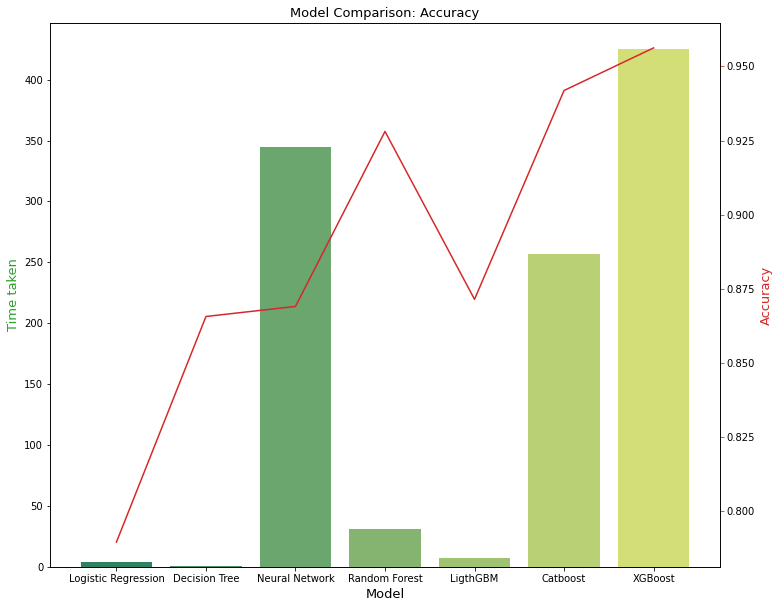

In [ ]:
accuracy_scores = [accuracy_lr, 
                   accuracy_dt, 
                   accuracy_nn,
                   accuracy_rf,
                   accuracy_lgb,
                   accuracy_cb, 
                   accuracy_xgb]

roc_auc_scores = [roc_auc_lr,
                  roc_auc_dt,
                  roc_auc_nn,
                  roc_auc_rf,
                  roc_auc_lgb,
                  roc_auc_cb,
                  roc_auc_xgb]                   

coh_kap_scores = [coh_kap_lr,
                  coh_kap_dt,
                  coh_kap_nn,
                  coh_kap_rf,
                  coh_kap_lgb,
                  coh_kap_cb,
                  coh_kap_xgb]

tt = [tt_lr,
      tt_dt,
      tt_nn,
      tt_rf,
      tt_lgb,
      tt_cb,
      tt_xgb]                                  

model_data = {'Model': ['Logistic Regression',
                        'Decision Tree',
                        'Neural Network',
                        'Random Forest',
                        'LigthGBM',
                        'Catboost',
                        'XGBoost'],
              'Accuracy': accuracy_scores,
              'ROC_AUC': roc_auc_scores,
              'Cohen_Kappa': coh_kap_scores,
              'Time taken': tt}

data = pd.DataFrame(model_data)

fig, ax1 = plt.subplots(figsize=(12,10))
ax1.set_title('Model Comparison: Accuracy', fontsize=13)
color = 'tab:green'
ax1.set_xlabel('Model', fontsize=13)
ax1.set_ylabel('Time taken', fontsize=13, color=color)
ax2 = sns.barplot(x='Model',
                  y='Time taken',
                  data=data,
                  palette='summer')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Accuracy', fontsize=13, color=color)
ax2 = sns.lineplot(x='Model', 
                   y='Accuracy', 
                   data=data,
                   sort=False,
                   color=color)
ax2.tick_params(axis='y', color=color)

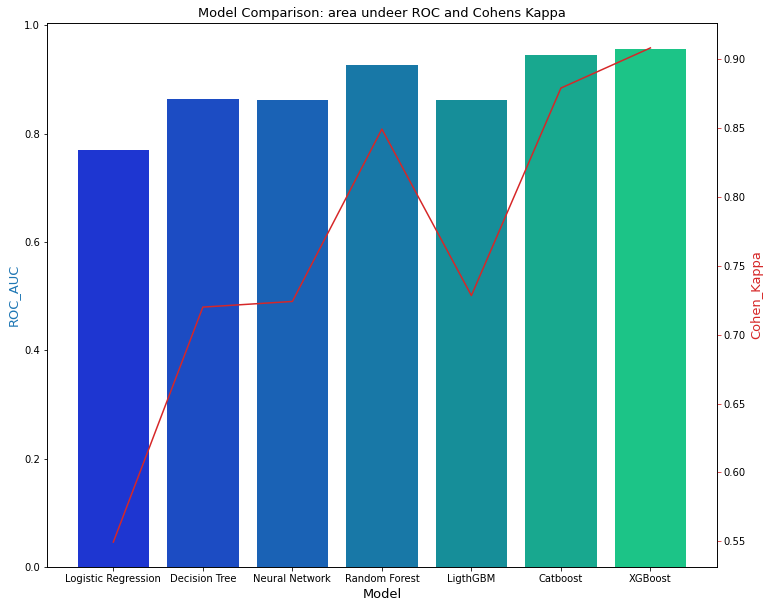

In [ ]:
fig, ax3 = plt.subplots(figsize=(12,10))
ax3.set_title('Model Comparison: area undeer ROC and Cohens Kappa', fontsize=13)
color = 'tab:blue'
ax3.set_xlabel('Model', fontsize=13)
ax3.set_ylabel('ROC_AUC', fontsize=13, color=color)
ax4 = sns.barplot(x='Model', 
                  y='ROC_AUC', 
                  data=data, 
                  palette='winter')
ax3.tick_params(axis='y')
ax4 = ax3.twinx()
color = 'tab:red'
ax4.set_ylabel('Cohen_Kappa', fontsize=13, color=color)
ax4 = sns.lineplot(x='Model',
                   y='Cohen_Kappa', 
                   data=data, 
                   sort=False, 
                   color=color)
ax4.tick_params(axis='y', color=color)
plt.show()
